In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
!pip install celltypist==1.5.3

In [5]:
import os
import re
import gc
from os.path import join

import anndata
import numpy as np
import pandas as pd
import xgboost as xgb
import dask.dataframe as dd
import pandas as pd
import lightning.pytorch as pl
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier, LinearClassifier, MLPClassifier
from utils import correct_labels, get_best_ckpts, macro_f1_per_group, BIONETWORK_GROUPING

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [6]:
from predictions import (
    get_count_matrix,
    eval_tabnet,
    eval_linear,
    eval_xgboost,
    eval_mlp,
    eval_celltypist
)

# Evaluate performance

In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

LOGS_TABNET = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
LOGS_LINEAR = '/mnt/dssfs02/tb_logs/juwles/cxg_2023_05_15_linear/default'
LOGS_XGBOOST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_xgboost'
LOGS_MLP = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_mlp/default'
LOGS_CELLTYPIST = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_celltypist'


CKPTS = {
    'xgboost': [join(LOGS_XGBOOST, f'version_20_{i}.json') for i in range(1, 6)],
    'xgboost_default': [join(LOGS_XGBOOST, f'default_params_{i}.json') for i in range(1, 5)],
    'tabnet': get_best_ckpts(LOGS_TABNET, [f'w_augment_{i}' for i in range(1, 6)]),
    'linear': get_best_ckpts(LOGS_LINEAR, [f'version_{i}' for i in range(1, 5)]),
    'MLP': get_best_ckpts(LOGS_MLP, [f'version_{i}' for i in range(3, 8)]),
    'celltypist': [join(LOGS_CELLTYPIST, f'model_1500000_cells_run{i}.pkl') for i in range(1, 5)],
    'celltypist_default': [join(LOGS_CELLTYPIST, f'model_1000000_cells_with_mean_run{i}.pkl') for i in range(1, 5)]
}

In [4]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()

## Overall

In [5]:
res = pd.read_csv('model_eval_cache/model_comparision.csv', index_col=0)

In [6]:
results = {'f1-score (macro avg.)': [], 'model': [], 'run': []}


for model, ckpts in CKPTS.items():
    if model not in res.model.tolist():
        if model == 'tabnet':
            preds = eval_tabnet(ckpts, DATA_PATH)
        elif model == 'linear':
            preds = eval_linear(ckpts, DATA_PATH)
        elif model == 'xgboost':
            preds = eval_xgboost(ckpts, DATA_PATH)
        elif model == 'xgboost_default':
            preds = eval_xgboost(ckpts, DATA_PATH)
        elif model == 'MLP':
            preds = eval_mlp(ckpts, DATA_PATH)
        elif model == 'celltypist':
            preds = eval_celltypist(ckpts, DATA_PATH)
        elif model == 'celltypist_default':
            preds = eval_celltypist(ckpts, DATA_PATH)
        else:
            raise ValueError

        for run, y_pred in enumerate(preds):
            y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
            clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
            results['f1-score (macro avg.)'].append(clf_report.loc['macro avg', 'f1-score'])
            results['model'].append(model)
            results['run'].append(f'{model}_run{run}')


In [7]:
res = pd.concat([res, pd.DataFrame(results)]).reset_index(drop=True)

In [8]:
res.to_csv('model_eval_cache/model_comparision.csv')

In [9]:
(
    res
    .groupby('model')['f1-score (macro avg.)']
    .aggregate(['mean', 'std'])
    .applymap("{0:.4f}".format)
)

,mean,std
model,,
MLP,0.7971,0.0012
celltypist,0.7304,0.0015
celltypist_default,0.6258,0.0036
linear,0.7848,0.0001
tabnet,0.8295,0.0007
xgboost,0.8127,0.0005
xgboost_default,0.5855,0.0112


In [10]:
(
    res[res.model.isin(['linear', 'tabnet'])]
    .groupby('model')['f1-score (macro avg.)']
    .aggregate(['mean', 'var'])
    .applymap("{0:.8f}".format)
)

,mean,var
model,,
linear,0.78483384,0.00000002
tabnet,0.82949732,0.00000055


In [11]:
f'{0.82949732 - 0.78483384:.4f}±{(0.00000055 + 0.00000002)**0.5:.4f}'

'0.0447±0.0008'

# Plot model comparision

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
model_comparision_df = pd.read_csv('model_eval_cache/model_comparision.csv', index_col=0)
model_comparision_df[~model_comparision_df.model.isin(['xgboost_default', 'celltypist_default'])]
model_comparision_df.sample(5)

,f1-score (macro avg.),model,run
1,0.813049,xgboost,xgboost_run1
0,0.812979,xgboost,xgboost_run0
10,0.784772,linear,linear_run0
18,0.795423,MLP,MLP_run4
29,0.628721,celltypist_default,celltypist_default_run2


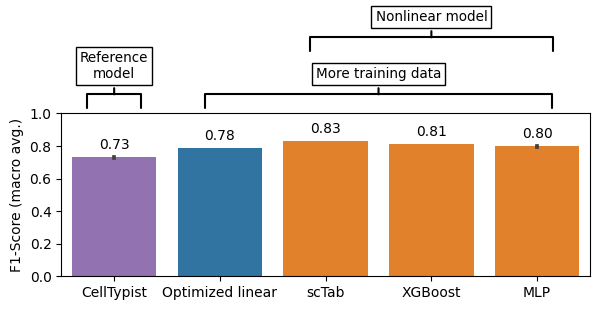

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6.1, 4))

ax = sns.barplot(
    x='model',
    y='f1-score (macro avg.)',
    order=['celltypist', 'linear', 'tabnet', 'xgboost', 'MLP'],
    errorbar='sd',
    palette=['#9467bd', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e'],
    data=model_comparision_df
)
ax.set_ylabel('F1-Score (macro avg.)')
ax.set_xlabel('')
ax.set_xticklabels(['CellTypist', 'Optimized linear', 'scTab', 'XGBoost', 'MLP'])
ax.set_ylim(0., 1.)


for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')


fs = 6.5
ax.annotate('Nonlinear model', xy=(0.7, 1.45), xytext=(0.7, 1.55), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=9., lengthB=1.', lw=1.5, color='k'))

ax.annotate('More training data', xy=(0.6, 1.1), xytext=(0.6, 1.2), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=12.8, lengthB=1.', lw=1.5, color='k'))

ax.annotate('Reference\nmodel', xy=(0.1, 1.1), xytext=(0.1, 1.2), xycoords='axes fraction', 
            fontsize=fs*1.5, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='-[, widthB=2., lengthB=1.', lw=1.5, color='k'))

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/model-comparision.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/model-comparision.png', dpi=300)

## Grouped by bionetwork

In [15]:
# only do this for TabNet + Linear model for now

In [ ]:
preds_tabnet = eval_tabnet(
    get_best_ckpts(LOGS_TABNET, [f'w_augment_{i}' for i in range(1, 6)]), DATA_PATH
)

In [ ]:
preds_linear = eval_linear(
    get_best_ckpts(LOGS_LINEAR, [f'version_{i}' for i in range(1, 5)]), DATA_PATH
)

In [53]:
tissue = tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
res = {'f1-score (macro avg.)': [], 'bionetwork': [], 'run': [], 'model': []}


for model, preds in [('TabNet', preds_tabnet), ('Linear', preds_linear)]:
    for i, y_pred in enumerate(preds):
        y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)
        f1_score_per_bionetwork = macro_f1_per_group(y_true, y_pred, tissue, BIONETWORK_GROUPING)
        res['f1-score (macro avg.)'] += f1_score_per_bionetwork.f1_score.tolist()
        res['bionetwork'] += f1_score_per_bionetwork.group.tolist()
        res['run'] += [f'run{i}'] * len(f1_score_per_bionetwork)
        res['model'] += [model] * len(f1_score_per_bionetwork)
        gc.collect()


In [54]:
df = pd.DataFrame(res)
df.to_csv('model_eval_cache/linear_vs_tabnet_per_organ.csv')

In [17]:
shortend_bionetworks = {
    'oral and craniofacial': 'craniofacial\noral',
    'blood and immune': 'blood\nimmune',
    'nervous system': 'nervous\nsystem',
    'musculoskeletal': 'musculo\nskeletal',
}

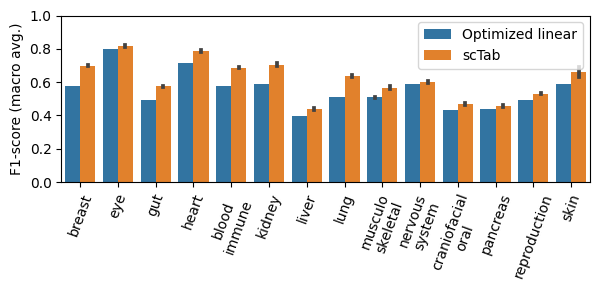

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6.1, 3.))

df = pd.read_csv('model_eval_cache/linear_vs_tabnet_per_organ.csv', index_col=0)
df['bionetwork'] = (
    df['bionetwork']
    .str.replace('_', ' ')
    .replace(shortend_bionetworks)
)
df['model'] = df.model.replace({'TabNet': 'scTab', 'Linear': 'Optimized linear'})
ax = sns.barplot(
    x='bionetwork',
    y='f1-score (macro avg.)',
    hue='model',
    hue_order=['Optimized linear', 'scTab'],
    data=df[df.bionetwork != 'adipose'],
    ax=ax,
)
ax.set_xlabel('')
ax.set_ylabel('F1-score (macro avg.)')
ax.tick_params(axis='x', labelrotation=70)
ax.legend(title='')
ax.set_ylim(0., 1.)

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/organ_wise_performance.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/organ_wise_performance.png', dpi=300)

# Organ-specific vs cross organ model

In [20]:
import pickle
import os

from statistics import mean, stdev
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score

In [21]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [22]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))

In [23]:
ORGANS = ['lung', 'kidney', 'heart', 'gut', 'breast', 'blood+immune']

In [24]:
logs_cross_organ_tabnet = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
logs_cross_organ_linear = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_linear/default'
ckpts_cross_organ_tabnet = get_best_ckpts(logs_cross_organ_tabnet, [f'w_augment_{i}' for i in range(1, 5)])
ckpts_cross_organ_linear = get_best_ckpts(logs_cross_organ_linear, [f'version_{i}' for i in range(1, 5)])


results = {'f1-score': [], 'organ': [], 'cross-organ': [], 'model': [], 'run': []}


for organ in ORGANS:
    data_path = f'/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p_{organ}_only'
    y_true = dd.read_parquet(join(data_path, 'test'), columns='cell_type').compute().to_numpy()
    logs_organ_specific_tabnet = f'/mnt/dssfs02/tb_logs/cxg_2023_05_15_{organ}_only_tabnet/default'
    logs_organ_specific_linear = f'/mnt/dssfs02/tb_logs/cxg_2023_05_15_{organ}_only_linear/default'

    ckpts_organ_specific_tabnet = get_best_ckpts(logs_organ_specific_tabnet, [f'version_{i}' for i in range(1, 5)])
    ckpts_organ_specific_linear = get_best_ckpts(logs_organ_specific_linear, [f'version_{i}' for i in range(1, 5)])
    
    if os.path.isfile(f'model_eval_cache/preds_{organ}.pkl'):
        with open(f'model_eval_cache/preds_{organ}.pkl', 'rb') as f:
            preds_cross_organ_tabnet, \
            preds_organ_specific_tabnet, \
            preds_cross_organ_linear, \
            preds_organ_specific_linear = pickle.load(f)
    else:
        preds_cross_organ_tabnet = eval_tabnet(ckpts_cross_organ_tabnet, data_path)
        preds_organ_specific_tabnet = eval_tabnet(ckpts_organ_specific_tabnet, data_path)
        preds_cross_organ_linear = eval_linear(ckpts_cross_organ_linear, data_path)
        preds_organ_specific_linear = eval_linear(ckpts_organ_specific_linear, data_path)
        with open(f'model_eval_cache/preds_{organ}.pkl', 'wb') as f:
            pickle.dump((
                preds_cross_organ_tabnet,
                preds_organ_specific_tabnet,
                preds_cross_organ_linear,
                preds_organ_specific_linear
            ), f)
    
    for cross_organ, model, preds in [
        (True, 'scTab', preds_cross_organ_tabnet),
        (False, 'scTab', preds_organ_specific_tabnet),
        (True, 'Optimized Linear', preds_cross_organ_linear),
        (False, 'Optimized Linear', preds_organ_specific_linear)
    ]:
        for i, y_pred in enumerate(preds):
            y_pred = correct_labels(y_true, y_pred, cell_type_hierarchy)
            results['f1-score'].append(f1_score(y_true, y_pred, average='macro', labels=np.unique(y_true)))
            results['organ'].append(organ)
            results['cross-organ'].append(cross_organ)
            results['model'].append(model)
            results['run'].append(i)


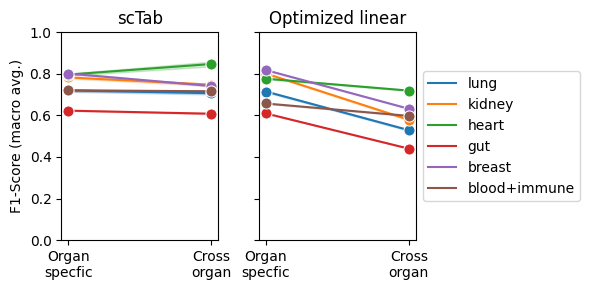

In [55]:
from pandas.api.types import CategoricalDtype

fig, ax = plt.subplots(1, 2, figsize=[6, 3], sharey=True, width_ratios=[1, 1])

data = pd.DataFrame(results)
data['cross-organ'] = (
    data['cross-organ']
    .replace({True: 'Cross\norgan', False: 'Organ\nspecfic'})
    .astype(CategoricalDtype(categories=['Organ\nspecfic', 'Cross\norgan'], ordered=True))
)
sns.lineplot(
    x='cross-organ',
    y='f1-score',
    hue='organ',
    data=data.query('model == "scTab"'),
    marker='o',
    markersize=8,
    sort=False,
    ax=ax[0]
)
sns.lineplot(
    x='cross-organ',
    y='f1-score',
    hue='organ',
    # hue_order=['Optimized Linear', 'scTab'],
    data=data.query('model == "Optimized Linear"'),
    marker='o',
    markersize=8,
    sort=False,
    ax=ax[1]
)

ax[0].set_title('scTab')
ax[1].set_title('Optimized linear')
ax[0].set_ylabel('F1-Score (macro avg.)')
ax[0].set_ylim(0, 1)
ax[0].get_legend().set_visible(False)
ax[1].legend(title='')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
# sns.move_legend(ax[1], 'upper left', bbox_to_anchor=(1, 0.95))
# handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, labels, loc='center left', bbox_to_anchor=(1., 0.5))

plt.tight_layout()
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/cross_organ_vs_organ_specific.pdf')
plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure2/cross_organ_vs_organ_specific.png', dpi=300)

# Reviewer 1 - Comment 6

6. In connection with the previous point, could the authors show whether the improvement between cross-organ and individual tissue models is driven by specific cell type classes? Do the classes driving the improvement in performance change according to tissue? Are misclassified cells always the same cell type? The authors could provide a scatter plot showing the correlation between per-class F1-scores in scTab versus the optimized linear model and show the actual cell type labels that vary the most between models.

In [1]:
import pickle
import os

from statistics import mean, stdev
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report

In [2]:
import yaml

with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'

In [7]:
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))

In [8]:
ORGANS = ['lung', 'kidney', 'heart', 'gut', 'breast', 'blood+immune']

In [9]:
logs_cross_organ_tabnet = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default'
logs_cross_organ_linear = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_linear/default'
ckpts_cross_organ_tabnet = get_best_ckpts(logs_cross_organ_tabnet, [f'w_augment_{i}' for i in range(1, 5)])
ckpts_cross_organ_linear = get_best_ckpts(logs_cross_organ_linear, [f'version_{i}' for i in range(1, 5)])


clf_reports = {organ: {'scTab': [], 'Optimized Linear': []} for organ in ORGANS}

for organ in ORGANS:
    data_path = f'/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p_{organ}_only'
    y_true = dd.read_parquet(join(data_path, 'test'), columns='cell_type').compute().to_numpy()
    
    if os.path.isfile(f'model_eval_cache/preds_{organ}.pkl'):
        with open(f'model_eval_cache/preds_{organ}.pkl', 'rb') as f:
            preds_cross_organ_tabnet, _, preds_cross_organ_linear, _ = pickle.load(f)
    else:
        raise RuntimeError('Run above section to compute predictions')
        
    for model, preds in [
        ('scTab', preds_cross_organ_tabnet),
        ('Optimized Linear', preds_cross_organ_linear)
    ]:
        for i, y_pred in enumerate(preds):
            y_pred = correct_labels(y_true, y_pred, cell_type_hierarchy)
            
            clf_reports[organ][model] += [pd.DataFrame(classification_report(
                y_true, 
                y_pred, 
                labels=np.unique(y_true),
                zero_division=0.,
                output_dict=True
            )).T]


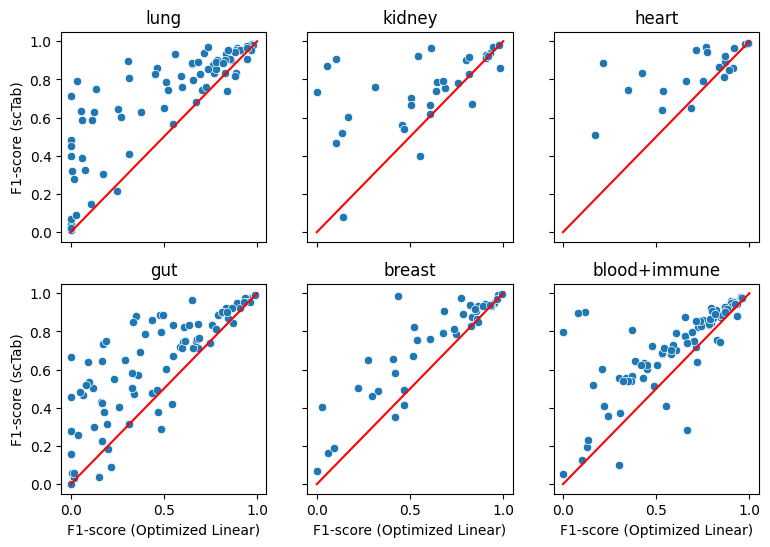

In [10]:
fig, axs = plt.subplots(2, 3, figsize=[9, 6], sharex=True, sharey=True)
biggest_difference = {}
scores = {}


def average_runs(reports):
    return np.stack([
        report['f1-score'].iloc[:-3].to_numpy() for report in reports
    ], axis=1).mean(axis=1)


for i, organ in enumerate(ORGANS):
    assert np.array_equal(
        clf_reports[organ]['scTab'][0].index.to_numpy(),
        clf_reports[organ]['Optimized Linear'][0].index.to_numpy()
    )
    index = clf_reports[organ]['scTab'][0].iloc[:-3].index.to_numpy()
    
    data = pd.DataFrame({
        'F1-score (scTab)': average_runs(clf_reports[organ]['scTab']),
        'F1-score (Optimized Linear)': average_runs(clf_reports[organ]['Optimized Linear']),
    }, index=index)
    
    ax = axs[np.unravel_index(i, (2, 3))]
    sns.scatterplot(
        data=data, 
        x='F1-score (Optimized Linear)', 
        y='F1-score (scTab)', 
        ax=ax
    )
    sns.lineplot(x=[0., 1.], y=[0., 1.], color='red', ax=ax)
    ax.set_title(f'{organ}')
    
    # find cell types with biggest difference
    biggest_difference[organ] = (
        (data['F1-score (scTab)'] -  data['F1-score (Optimized Linear)'])
        .sort_values(ascending=False)
        .rename_axis('cell_type').reset_index()
        .rename(columns={0: 'f1_score_diff'})
        .assign(
            cell_type=lambda df: df.cell_type.astype(int).replace(cell_type_mapping.label.to_dict())
        )
    )
    scores[organ] = data 


In [11]:
from IPython.display import display, Markdown


def list_to_markdown(lst, indentation=0):
    markdown = ""
    for item in lst:
        if isinstance(item, list):
            markdown += list_to_markdown(item, indentation + 2)
        else:
            markdown += " " * indentation + "- " + str(item) + "\n"
    return markdown


for organ, differences in biggest_difference.items():
    display(Markdown(f'**{organ}**'))
    differences = differences.iloc[:7]
    display(Markdown(list_to_markdown(differences.cell_type.to_list())))


**lung**

- CD4-positive helper T cell
- T-helper 17 cell
- Schwann cell
- CD16-positive, CD56-dim natural killer cell, human
- CD8-positive, alpha-beta cytotoxic T cell
- vascular associated smooth muscle cell
- effector memory CD8-positive, alpha-beta T cell


**kidney**

- pericyte
- conventional dendritic cell
- alternatively activated macrophage
- monocyte
- CD4-positive, alpha-beta T cell
- non-classical monocyte
- renal interstitial pericyte


**heart**

- lymphoid lineage restricted progenitor cell
- Schwann cell
- mature NK T cell
- vein endothelial cell
- immature innate lymphoid cell
- capillary endothelial cell
- lymphocyte


**gut**

- effector memory CD8-positive, alpha-beta T cell, terminally differentiated
- erythroblast
- myoepithelial cell of mammary gland
- T follicular helper cell
- CD16-negative, CD56-bright natural killer cell, human
- CD8-alpha-alpha-positive, alpha-beta intraepithelial T cell
- precursor B cell


**breast**

- myoepithelial cell of mammary gland
- gamma-delta T cell
- naive B cell
- effector memory CD8-positive, alpha-beta T cell
- mature NK T cell
- activated CD8-positive, alpha-beta T cell
- class switched memory B cell


**blood+immune**

- pro-B cell
- immature innate lymphoid cell
- precursor B cell
- promonocyte
- effector memory CD8-positive, alpha-beta T cell, terminally differentiated
- IgA plasma cell
- activated CD4-positive, alpha-beta T cell


In [ ]:
# Schwann cell (neuron subtype) in lung: https://cellxgene.cziscience.com/e/3dc61ca1-ce40-46b6-8337-f27260fd9a03.cxg/
# neuron in lung: https://cellxgene.cziscience.com/e/d8da613f-e681-4c69-b463-e94f5e66847f.cxg/
# vascular associated smooth muscle cell in kidney: https://cellxgene.cziscience.com/e/be39785b-67cb-4177-be19-a40ee3747e45.cxg/
# lymphoid lineage restricted progenitor cell in heart: https://cellxgene.cziscience.com/e/1c739a3e-c3f5-49d5-98e0-73975e751201.cxg/

In [12]:
for organ, score_tissue in scores.items():
    display(Markdown(f'**{organ}**'))
    score_tissue = differences.iloc[-10:]
    display(Markdown(list_to_markdown([
        cell_type_mapping.label.to_dict()[int(elem)] for elem in
        scores[organ]['F1-score (scTab)'].sort_values().iloc[:3].index.tolist()
    ])))

**lung**

- intermediate monocyte
- naive thymus-derived CD8-positive, alpha-beta T cell
- effector CD8-positive, alpha-beta T cell


**kidney**

- CD4-positive helper T cell
- CD8-positive, alpha-beta T cell
- capillary endothelial cell


**heart**

- vein endothelial cell
- B cell
- endothelial cell of artery


**gut**

- alveolar macrophage
- inflammatory macrophage
- T-helper 17 cell


**breast**

- CD8-positive, alpha-beta T cell
- B cell
- memory B cell


**blood+immune**

- lymphoid lineage restricted progenitor cell
- capillary endothelial cell
- pericyte
